# Semana 3: Extensión y mejora del pipeline

## 1. Justificación de la mejora propuesta
Se puede agregar la normalización de los datos, considerando la distribución de los datos (función logarítmica para datos 
sesgados hacia un extremo, y escala estandarizada para datos 
distribuidos en campana). 

Además, agregar un balanceo de clases con la técnica SMOTE, la cual crea datos artificiales a partir de existentes con el objetivo de igualar la cantidad de datos en ambas etiquetas debido a su desbalance. Esto reduciría accuracy, sin embargo, debería aumentar el porcentaje de precisión, ya que el desbalance probablemente está desajustando la medición.

Junto con esto, se evaluarán otros modelos para comparar con el resultado inicial.






## 2. Implementación (modelo nuevo, nuevas features, etc.)

### Cargar el dataset


In [11]:
# obtener datos de ecg_rr_features_extracted.csv
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Configuración de la ruta del directorio
current_dir = os.getcwd()
# Ruta al archivo CSV
csv_file = os.path.join(current_dir, '..\data\ecg_rr_features_complete.csv')
# Cargar el archivo CSV
df = pd.read_csv(csv_file)
# Ver datos del DataFrame
print("Datos del DataFrame:")
print(df.head())

print("\nCantidad de filas y columnas:")    
print(df.shape)

Datos del DataFrame:
      mean_rr      std_rr   skew_rr    kurt_rr label
0  761.666667   33.093435  0.133439   1.811500     N
1  867.575758  251.388431 -1.267438   2.884663     N
2  731.434599   79.934367 -2.918037  14.419521     N
3  947.111111  178.938709  0.482376   2.062416     A
4  542.324159  223.975072  1.170247   2.981416     A

Cantidad de filas y columnas:
(8527, 5)


<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\valen\AppData\Local\Temp\ipykernel_10840\2278839408.py:11: SyntaxWarning: invalid escape sequence '\d'
  csv_file = os.path.join(current_dir, '..\data\ecg_rr_features_complete.csv')


### Selección de labels
Se considerará sólo 'N' y 'A' como labels válidas.

In [12]:
# mantener sólo labels de tipo 'N' y 'A'
df = df[df['label'].isin(['N', 'A'])]
print("\nDatos del DataFrame filtrados:")
print(df.head())
print("\n labels únicos después del filtrado:")
print(df['label'].unique())

# Cantidad de Ns
n = df[df['label'] == 'N'].shape[0]
# Cantidad de As
a = df[df['label'] == 'A'].shape[0]
print("\nCantidad de N:", n)
print("Cantidad de A:", a)


Datos del DataFrame filtrados:
      mean_rr      std_rr   skew_rr    kurt_rr label
0  761.666667   33.093435  0.133439   1.811500     N
1  867.575758  251.388431 -1.267438   2.884663     N
2  731.434599   79.934367 -2.918037  14.419521     N
3  947.111111  178.938709  0.482376   2.062416     A
4  542.324159  223.975072  1.170247   2.981416     A

 labels únicos después del filtrado:
['N' 'A']

Cantidad de N: 5050
Cantidad de A: 738


In [13]:
# Separar características y etiquetas
X = df.drop('label', axis=1)
y = df['label']

# Verificar valores faltantes antes de aplicar SMOTE
print("Valores faltantes en X:")
print(X.isnull().sum())

print("\nValores faltantes en y:")
print(y.isnull().sum())

# Eliminar filas con valores faltantes si existen
if X.isnull().any().any() or y.isnull().any():
    print("Eliminando filas con valores faltantes...")
    # Crear máscara para filas sin valores faltantes
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X_clean = X[mask]
    y_clean = y[mask]
else:
    X_clean = X
    y_clean = y

print(f"Forma final de X: {X_clean.shape}")
print(f"Forma final de y: {y_clean.shape}")

Valores faltantes en X:
mean_rr    0
std_rr     0
skew_rr    0
kurt_rr    0
dtype: int64

Valores faltantes en y:
0
Forma final de X: (5788, 4)
Forma final de y: (5788,)


#### Aplicación de SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos balanceados
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['label'] = y_resampled

print("\nDatos después de aplicar SMOTE:")
print(df_resampled['label'].value_counts())


Datos después de aplicar SMOTE:
label
N    5050
A    5050
Name: count, dtype: int64


#### Normalizar los datos
Se aplica Standar Scaler para `mean_rr` y `skew_rr`. Para `kurt_rr` y `std_rr` función logarítmica con el objetivo de reducir la diferencia de importancia de ciertos atributos frente a otros a la hora de entrenar el modelo.

In [15]:
# aplicación de Standar Scaler
from sklearn.preprocessing import StandardScaler
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled[['mean_rr', 'skew_rr']])
# Aplicar logaritmo a 'kurt_rr' y 'std_rr'
X_scaled = pd.DataFrame(X_scaled, columns=['mean_rr', 'skew_rr'])

X_scaled['kurt_rr'] = np.log1p(X_resampled['kurt_rr'])
X_scaled['std_rr'] = np.log1p(X_resampled['std_rr'])
# Concatenar las características normalizadas con las etiquetas
df_scaled = pd.DataFrame(X_scaled, columns=['mean_rr', 'skew_rr', 'kurt_rr', 'std_rr'])
df_scaled['label'] = y_resampled.reset_index(drop=True)
print("\nDatos después de la normalización:")
print(df_scaled.head())
# Guardar el DataFrame balanceado y normalizado en un nuevo archivo CSV


Datos después de la normalización:
    mean_rr   skew_rr   kurt_rr    std_rr label
0 -0.107758 -0.057325  1.033718  3.529105     N
1  0.472560 -1.042171  1.357036  5.530969     N
2 -0.273412 -2.202576  2.735634  4.393639     N
3  0.908365  0.187984  1.119204  5.192616     A
4 -1.309623  0.671572  1.381637  5.415990     A


# Entrenar modelos nuevos

#### Modelo Random Forest nuevo




Características más importantes:
   feature  importance
0  mean_rr    0.329001
1   std_rr    0.280979
2  skew_rr    0.213681
3  kurt_rr    0.176340


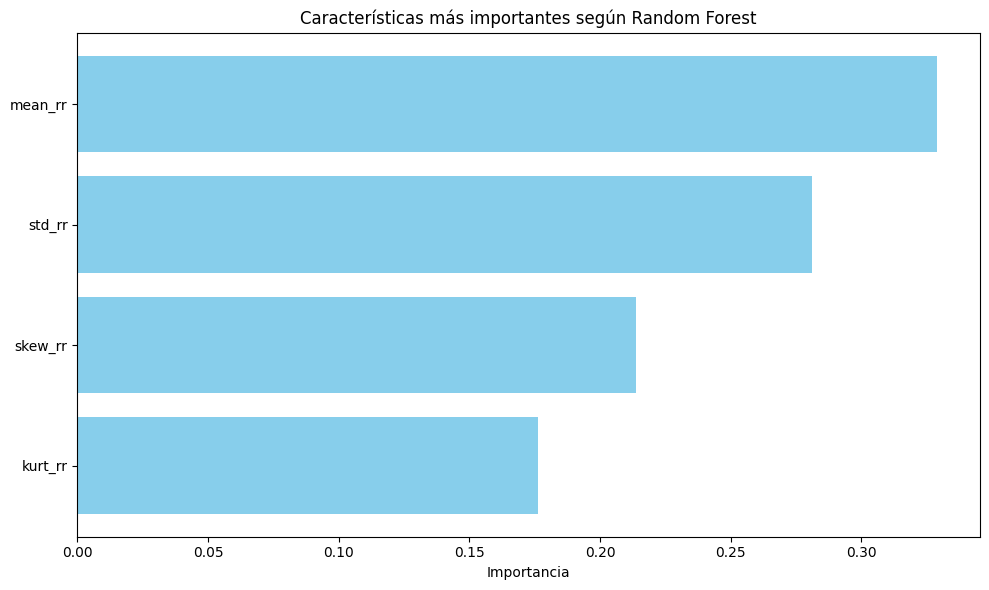

In [16]:
# aplicar random forest para obtener las características más importantes
from sklearn.ensemble import RandomForestClassifier
# Separar características y etiquetas
X = df.drop(columns=['label'])
y = df['label']
# Crear el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Entrenar el modelo
rf.fit(X, y)
# Obtener la importancia de las características
importances = rf.feature_importances_
# Crear un DataFrame para las importancias
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
# Ordenar las importancias de mayor a menor
importance_df = importance_df.sort_values(by='importance', ascending=False)
# Mostrar las características más importantes
print("\nCaracterísticas más importantes:")
print(importance_df.head(10))

# Graficar las importancias
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:10], importance_df['importance'][:10], color='skyblue')
plt.xlabel('Importancia')
plt.title('Características más importantes según Random Forest')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la más importante en la parte superior
plt.tight_layout()
plt.show()

# Evaluación de los modelos

In [25]:
# dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("\nDimensiones del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Dimensiones del conjunto de prueba:", X_test.shape, y_test.shape)



Dimensiones del conjunto de entrenamiento: (4630, 4) (4630,)
Dimensiones del conjunto de prueba: (1158, 4) (1158,)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Codificar etiquetas para XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Diccionario de modelos
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
}

results = []

for name, model in models.items():
    print(f"Entrenando {name}...")
    
    # Para XGBoost usar etiquetas codificadas
    if name == 'XGBoost':
        model.fit(X_train, y_train_encoded)
        y_pred_encoded = model.predict(X_test)
        y_pred = label_encoder.inverse_transform(y_pred_encoded)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label='A')
    precision = precision_score(y_test, y_pred, pos_label='A')
    recall = recall_score(y_test, y_pred, pos_label='A')
    
    results.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"{name} - F1: {f1:.3f}, Accuracy: {accuracy:.3f}")

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("COMPARACIÓN FINAL DE MODELOS:")
print("="*60)
print(results_df.round(3))

# Encontrar el mejor modelo
best_model_idx = results_df['F1-Score'].idxmax()
best_model = results_df.loc[best_model_idx]
print(f"\nMEJOR MODELO: {best_model['Modelo']}")
print(f"F1-Score: {best_model['F1-Score']:.3f}")
print(f"Accuracy: {best_model['Accuracy']:.3f}")
print(f"Precision: {best_model['Precision']:.3f}")
print(f"Recall: {best_model['Recall']:.3f}")

Entrenando Random Forest...
Random Forest - F1: 0.859, Accuracy: 0.964
Entrenando Gradient Boosting...
Gradient Boosting - F1: 0.842, Accuracy: 0.959
Entrenando Logistic Regression...
Logistic Regression - F1: 0.700, Accuracy: 0.928
Entrenando XGBoost...
XGBoost - F1: 0.835, Accuracy: 0.958

COMPARACIÓN FINAL DE MODELOS:
                Modelo  Accuracy  F1-Score  Precision  Recall
0        Random Forest     0.964     0.859      0.853   0.865
1    Gradient Boosting     0.959     0.842      0.839   0.845
2  Logistic Regression     0.928     0.700      0.752   0.655
3              XGBoost     0.958     0.835      0.832   0.838

🏆 MEJOR MODELO: Random Forest
F1-Score: 0.859
Accuracy: 0.964
Precision: 0.853
Recall: 0.865


c:\Users\valen\OneDrive\Documentos\repo\proyectoML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:10:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Conclusiones
Finalmente, a pesar de las mejoras parea el rendimiento del modelo `Random Forest` no cambió en nada significativo. Se evaluaron otros modelos como  `Gradient Boosting`,`Logistic Regression` y `XGBoost`, sin embargo el modelo más eficiente termina siento Random Forest igualmente